# Discord starboard stats

## _Data processing_

You should obtain **`starboard.json`** **with the explicit approval of the Discord server in use**. For obvious reasons I'm not going to tell you how to automatically get channel data (hint: use a bot!) but you should follow the schema in the example. The `"embeds"` key contains the original message and a URL.

In the **`misc_stats.json`**, you may  have the dictionaries under `name_mapping`, `name_msgs` and `chan_msgs` empty. `name_mapping` is useful to coalesce old usernames; the `_msgs` keys are a total message count (use ctrl-F!).

The `bot_` keys, however, are used for processing. Change them if you're not using Dyno.

In [1]:
import json
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.dates as mdates

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
with open('misc_stats.json') as f:
    MISC_STATS = json.load(f)

print(MISC_STATS['bot_content_regex'])
print(MISC_STATS['bot_field_regex'])

⭐ \*\*(?P<stars>\d+)\*\* \| #(?P<channel>.+)
\*\*\[Click to jump to message!\]\((?P<url>.+?)\)\*\*


In [4]:
RE_MSG = re.compile(MISC_STATS['bot_content_regex'])
RE_FIELD = re.compile(MISC_STATS['bot_field_regex'])

def process_message(msg: dict):
    orig_msg = msg['embeds'][0]
    assert orig_msg['timestamp'] and orig_msg['author']
    assert 'timestampEdited' in msg or 'timestamp' in msg

    re_msg = RE_MSG.match(msg['content'])
    re_field_groups = {}
    for f in orig_msg['fields']:
        if re_field := RE_FIELD.match(f['value']):
            re_field_groups = re_field.groupdict()

    stats = re_msg.groupdict() | re_field_groups

    stats['stars'] = int(stats['stars'])

    hall_stars = 0
    for r in msg['reactions']:
        if r['emoji']['code'] == 'star':
            hall_stars = r['count']
            break

    stats.update({
        'hall_stars': hall_stars,
        'sent_at': orig_msg['timestamp'],
        'author_id': orig_msg['author']['name'],
        'content': orig_msg['description'],
        'last_starred_at': msg.get('timestampEdited') or msg['timestamp'],
    })
    return stats

with open("starboard.json") as f:
    stats = pd.DataFrame([
        process_message(msg) for msg in json.load(f)
        if msg['author']['nickname'] == MISC_STATS['bot_name']
        ])

stats['sent_at'] = pd.to_datetime(stats['sent_at'], format='ISO8601', utc=True)
stats['last_starred_at'] = pd.to_datetime(stats['last_starred_at'], format='ISO8601', utc=True)


## Data

In [5]:
with pd.option_context('display.max_colwidth', None):
    display(stats[['channel', 'sent_at', 'author_id', 'content', 'stars']].loc[:10])

,channel,sent_at,author_id,content,stars
0,general,2021-04-23 22:56:26.734000+00:00,Kintay#1234,For Iris! The queen of the nerds.,35
1,arts-and-crafts,2021-04-26 02:45:50.311000+00:00,Anto#3933,"Another ghibli watercolor art that I made. Decided to draw Kiki in my style, and didn't succeed much lol but it was fun to paint.",28
2,arts-and-crafts,2021-04-26 03:33:48.826000+00:00,ARCAName#6354,if you remember i sent here the first part of the picture... so this is finished:,28
3,music,2021-04-30 03:00:25.039000+00:00,lito#4187,"Guys, i did something 😬",27
4,memes,2021-04-30 17:53:27.202000+00:00,acheleo#6084,I am pretty sure\nall of us would like to see\nbigger boobs Tohawk,21
5,general,2021-05-01 11:12:03.453000+00:00,Breton#2337,Brace is a violation of Federal Law,19
6,general,2021-05-02 02:02:34.054000+00:00,Tilly#7777,Bread is the best friend of the world,19
7,epic-rpg-chat,2021-05-02 17:56:05.982000+00:00,Falfactor#2952,@deleted-role It was minutes before noon on the 2nd of May when the citizens of the Bot were able to work out their differences. The Amyr and the Chandrian forged a truce born of friendship. The guilds were merged into unity as the Edema Ruh. One family.,26
8,general,2021-05-04 14:25:07.771000+00:00,Breton#2337,"Her Majesty, Princess @Anto of Teampire,\n\nMost honoured Princess of Teampire, as an appointed ambassador, I am writing you in hopes of soothing tensions betwixt thee and one of beholden unto the Kingdom of Bread an Pastry. \n\nIn recent hours, it has been bought to my foresight that Lord Jackass of Bagel has offended some sensibility. This was not his intention. \n\nTruly the T.E. is a great empire and of moral standards most accute. We knead not let one event interrupt an air of mutual value and interest. \n\nSincerely,\nHis Grace Breton,\nDucal Prince of Brioche",20
9,general,2021-05-04 16:50:46.439000+00:00,Anto#3933,"Dear Ducal Prince of Brioche @Brace \n\nI have received the previous letter and we have been discussing internally the matters so this won't escalate further into conflict between our lands. Despite me being just one of the princess,with no so much power in external affairs, I will accept the apology and forgive Sir Lord Jackass of Bagel in the name of our Great Queen, so lets forget this matter.\n\nSincerely,\nPrincess Antonia of the TeaEmpire",19


## _Reusable functions_

These are useful for any dataviz stuff! Feel free to use them wherever!

In [6]:
def groupbysort(df: pd.DataFrame, key: str, size_min: int | None = None, other_label='other', ascending=False):
    "df.groupby(key), except most common groups first, and groups with N < size_min renamed to other_label"
    df = df.copy()
    sizes = df.groupby(key).size().sort_values(ascending=ascending)
    if size_min is not None:
        excluded = sizes.index.difference(sizes.head(size_min).index)
        df.loc[df[key].isin(excluded), key] = other_label
        sizes = df.groupby(key).size().sort_values(ascending=ascending)
        sizes = pd.concat([sizes.drop(other_label), sizes.loc[[other_label]]])

    return df.set_index(key).loc[sizes.index].reset_index().groupby(key, sort=False)

def period_start(dt: pd.Series, freq: str):
    return dt.dt.to_period(freq).apply(lambda s: s.start_time).dt.tz_localize('UTC')

The following is useful specifically for starboard data!

In [7]:
def star_stats_grouped_by(
    key: str,
    total_msg_count: dict[str, int] = None,
    sort: bool = True,
):
    """
    Group message stats by a column, optionally sorting by total star count.

    Set `total_msg_count` if you want to use a custom dataset to log how many
    messages that group has in total.
    """
    s = stats.groupby(key)['stars']
    df = pd.concat([s.sum(), s.count()], axis=1, keys=['stars', 'starred msgs'])
    df['avg stars'] = (df['stars'] / df['starred msgs']).round(1)
    if total_msg_count is not None:
        df['total msgs'] = df.index.to_series().apply(
            lambda x: total_msg_count.get(x, float('nan')))
        df['total msgs per star'] = (df['total msgs'] / df['stars']).round(2)
        #.apply(total_msg_count.get)
    if sort:
        df.sort_values('stars', ascending=False, inplace=True)
    return df

## _Matplotlib styling_

The fonts will be weird because my laptop broke - please send it well wishes to be fixed soon!

### Colours and other styling

In [8]:
from cycler import cycler

pyplot.style.use('seaborn-v0_8')
rc = pyplot.rcParams
rc['axes.prop_cycle'] = cycler(color=pyplot.cm.tab10.colors)

rc['figure.facecolor'] = '#EFDCC3'
COL_DARK = '#9A6522'
rc['text.color']        = COL_DARK
rc['axes.labelcolor']   = COL_DARK
rc['xtick.color']       = COL_DARK
rc['ytick.color']       = COL_DARK

### Fonts

In [9]:
TITLE = dict()
FONT_TEXT = 'sans'

def get_font(path):
    from matplotlib import font_manager as fm
    fm.fontManager.addfont(path)
    return fm.FontProperties(fname=path).get_name()

try:
    FONT_TEXT = get_font("/Users/yunruse/Library/Fonts/Calamity-Bold.otf")
except FileNotFoundError:
    # I use a custom font, Calamity, used in The Legend of Zelda: Breath of the Wild.
    # It's Nintendo's own variant of Rodin by Fontworks.
    # It's sadly no longer publically availble but some very good approximations are:
    # https://fontoteka.com/font/sce-ps3-rodin-latin-italic
    # https://www.deviantart.com/mayugaph/art/Hagiwara-MattMayuga-s-custom-edit-of-Rodin-915140891
    # or, well, just use a different font, lol.
    pass

# If you have the Cochin font, change it here!
# TITLE = dict(fontfamily='Cochin', fontsize=20)

rc['font.family'] = FONT_TEXT
rc['font.weight'] = 'bold'

## Total number of stars

In [10]:
TIME_START = stats['sent_at'].min()
N_MSGS = stats['stars'].count()
print(f'{N_MSGS} starred messages since {TIME_START}')

SUM_STARS = stats['stars'].sum()
MAX_STARS = stats['stars'].max()
AVG_STARS = stats['stars'].mean()
MED_STARS = stats['stars'].median()
print(f'sum {SUM_STARS}, ax {MAX_STARS}, avg {AVG_STARS:.2f}, median {MED_STARS:.0f}')

1468 starred messages since 2021-04-23 22:56:26.734000+00:00
sum 23994, ax 69, avg 16.34, median 15


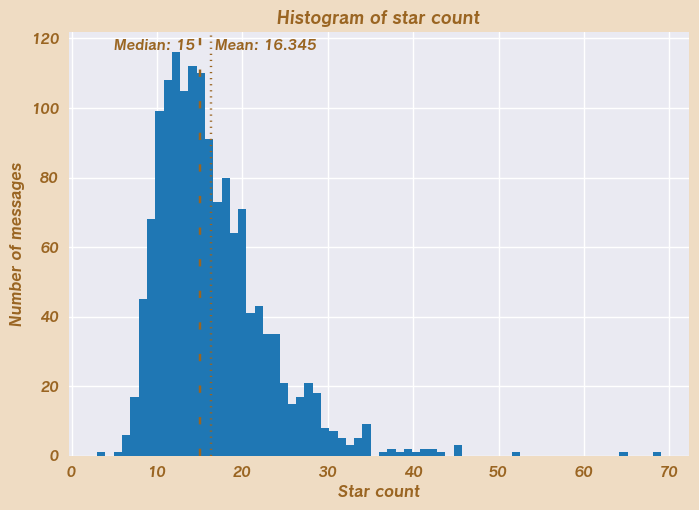

In [11]:
pyplot.title('Histogram of star count', **TITLE)
pyplot.ylabel('Number of messages')
pyplot.xlabel('Star count')
pyplot.axvline(AVG_STARS, color=COL_DARK, dashes=[0.5, 2])
pyplot.axvline(MED_STARS, color=COL_DARK, dashes=[3, 10])
pyplot.annotate(
    f'Median: {MED_STARS:.0f}',
    (MED_STARS - 0.5, 120),
    verticalalignment='top',
    horizontalalignment='right',
)
pyplot.annotate(
    f'Mean: {AVG_STARS:.3f}',
    (AVG_STARS + 0.5, 120),
    verticalalignment='top',
    horizontalalignment='left',
)
pyplot.hist(stats['stars'], bins=MAX_STARS-1);

## Leaderboards

### Channels

In [12]:
cs = star_stats_grouped_by('channel', MISC_STATS['chan_msgs'])
# cs = cs[cs['stars'] > 100][cs['total msgs'] > 0]

cs.sort_values('total msgs', ascending=False)[['total msgs', 'stars']]

,total msgs,stars
channel,,
general,1699792.0,4365
active-voice-chat,111094.0,691
slice-of-life,81165.0,2689
memes,65225.0,2253
activities,54930.0,683
off-topic,51535.0,2500
question-of-the-day,35939.0,1173
fantastic-beasts,24864.0,437
music,16334.0,554


### Messages

In [13]:
ms = stats.sort_values('stars', ascending=False)
ms[['stars', 'author_id', 'content', 'url']][:9]

,stars,author_id,content,url
88,69,Graspurv#9681,We did the thing!,https://discord.com/channels/38634598846758912...
209,65,Celestialle#9711,,https://discord.com/channels/38634598846758912...
418,52,dela_mamacita#0001,HI FROM US,https://discord.com/channels/38634598846758912...
337,45,123jellybean#9995,TEARS OF JOY,https://discord.com/channels/38634598846758912...
37,45,Kintay#1234,Proud.,https://discord.com/channels/38634598846758912...
979,45,Graspurv#9681,so i have some pretty big news to share :llama...,https://discord.com/channels/38634598846758912...
228,43,Anto#3933,This place has been a real safe-space for me. ...,https://discord.com/channels/38634598846758912...
199,42,b.sodie#0395,i have exciting news 🙂 i'm finally on spotify ...,https://discord.com/channels/38634598846758912...
275,42,Tilly#7777,Drew this as @ɹɐloɥɔs ǝɥʇ ƃɹoz's secret santa ...,https://discord.com/channels/38634598846758912...


### Users

In [14]:
def name_lookup(name: str):
    if name.startswith('|redacted|'):
        return None
    name = name.split('#', 1)[0]
    name = MISC_STATS['name_mapping'].get(name, name)
    name = name.lower()
    name = name.replace(' ', '').replace('_', '').replace('.', '').replace('\\', '')
    return name


stats['author'] = stats['author_id'].apply(name_lookup)

by_author = star_stats_grouped_by('author').reset_index()
by_author = by_author.sort_values('stars', ascending=False)
by_author['total_msgs'] = by_author['author'].apply(
    lambda s: MISC_STATS['name_msgs'].get(s, None)) / 1000
by_author['msgs_per_star'] = by_author['total_msgs'] / by_author['stars']
by_author[:16]

# set(by_author.index)

,author,stars,starred msgs,avg stars,total_msgs,msgs_per_star
0,coppito,1482,91,16.3,63.0,0.042510
1,polarys,1412,78,18.1,19.4,0.013739
2,altheazorg,1122,66,17.0,41.8,0.037255
3,gaia,1074,67,16.0,55.1,0.051304
4,faeus,1051,78,13.5,NaN,NaN
5,caesura,826,50,16.5,24.9,0.030145
6,graspurv,754,36,20.9,14.2,0.018833
7,yunruse,561,36,15.6,17.8,0.031729
8,123jellybean,545,32,17.0,102.9,0.188807
9,celestialle,519,27,19.2,30.9,0.059538


## Time plots

### Stars over time

In [15]:
# Helper setup code!

stats['month'] = stats['sent_at'].dt.to_period('M')
month_stars = star_stats_grouped_by('month').reset_index()

def center_month(m: pd.Series):
    start = m.dt.to_timestamp()
    end = (m + 1).dt.to_timestamp()
    return start + (end-start) / 2
month_stars['month_center'] = center_month(month_stars['month'])

previous_month = center_month((month_stars['month'] - 1)).min()

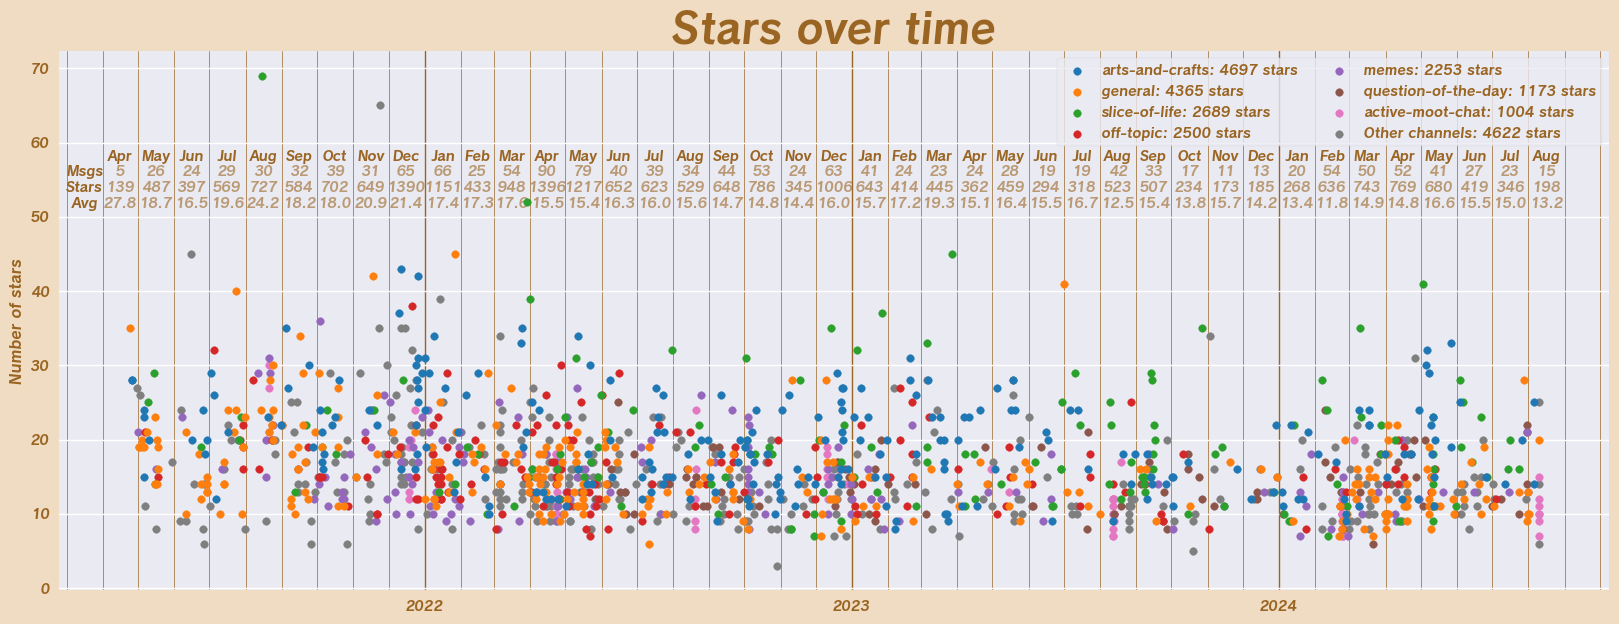

In [16]:
fig, ax = pyplot.subplots(figsize=(20, 7))
ax: pyplot.Axes
ax.set_title('Stars over time', **TITLE | dict(fontsize=30))
ax.set_ylabel('Number of stars')

# chan_group.sort()

chans = sorted(list(stats.groupby('channel')), key=lambda s: s[1]['stars'].sum(), reverse=True)
notability_limit = chans[6][1]['stars'].count()
other_seen = False
n_seen = 0
zorder = 100 # We want to reverse the order
for name, g in chans:
    alpha = 1
    # if name != 'active-moot-chat':
    #     alpha = 0.1
    zorder -= 1
    sum_stars = g['stars'].sum()
    n_seen += sum_stars
    label = f'{name}: {sum_stars} stars'
    color = None
    if g['stars'].count() < notability_limit:
        label = None
        color = 'tab:gray'
        if not other_seen:
            label = f'Other channels: {SUM_STARS - n_seen} stars'
            other_seen = True
    ax.scatter(g['sent_at'], g['stars'], color=color, label=label, s=30, alpha=alpha, zorder=zorder)

ax.legend(ncols=2, facecolor='#EAEAF2', frameon=True, prop={'weight': 'regular'} )

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.grid(axis='x', which='major', lw=1, c=COL_DARK)

ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='minor', labelsize=7)
ax.grid(axis='x', which='minor', lw=0.5, c=COL_DARK)

#% Month labels
for m in month_stars.itertuples():
    ax.annotate(m.month.strftime('%b'), (m.month_center, MAX_STARS - 10), horizontalalignment='center', verticalalignment='top')
    messages = m._3
    label = f'{messages}\n{m.stars}\n{m.stars / messages:.1f}'
    ax.annotate(label, (m.month_center, MAX_STARS - 12), horizontalalignment='center', verticalalignment='top', alpha=0.6)

ax.annotate('Msgs\nStars\nAvg', (previous_month, MAX_STARS - 12), horizontalalignment='center', verticalalignment='top');

### Starred messages over the day

In [17]:
MONTHS = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
WEEKDAYS = 'Mon Tue Wed Thu Fri Sat Sun'.split()
DAY_SECS = 24 * 60 * 60

In [18]:
def plot_msgs(period: str, bins: int, key = 'TEMP'):
    pyplot.ylabel('Number of starred messages');
    stats[key] = (stats['sent_at'] - period_start(stats['sent_at'], period)).dt.total_seconds() / DAY_SECS
    labels, bars = list(zip(*groupbysort(stats, 'channel', size_min=7, other_label='other')[key]))
    cmap = pyplot.cm.tab10.colors[:len(labels)]
    pyplot.hist(bars, bins=bins, stacked=True, label=labels, color=cmap, zorder=0);
    pyplot.legend(ncols=2);

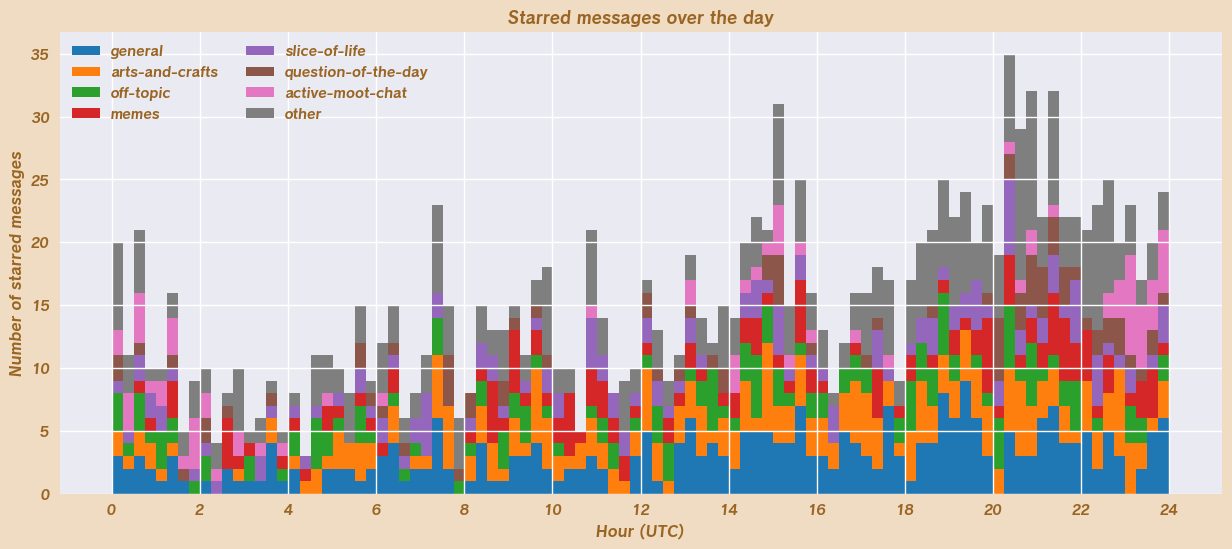

In [19]:
fig, ax = pyplot.subplots(figsize=(15, 6))
ax: pyplot.Axes
pyplot.title('Starred messages over the day', **TITLE)
pyplot.xlabel('Hour (UTC)')
plot_msgs('D', bins=96)
pyplot.xticks(np.arange(13) / 12, np.arange(13) * 2);

### Starred messages over the week

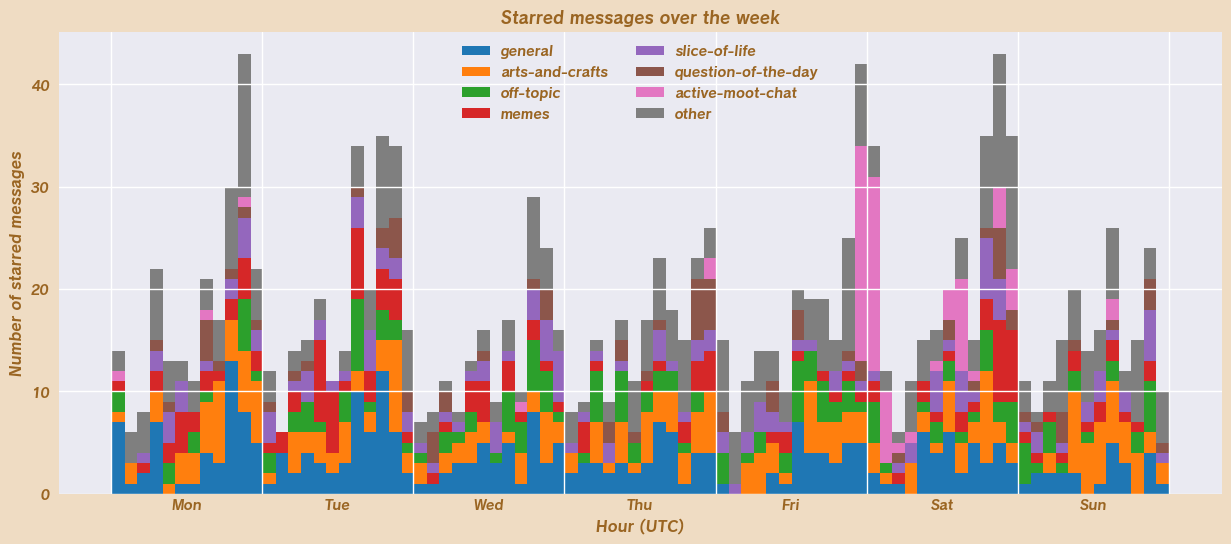

In [20]:
fig, ax = pyplot.subplots(figsize=(15, 6))
pyplot.title('Starred messages over the week', **TITLE)
pyplot.xlabel('Hour (UTC)')
plot_msgs('W', bins=7*12)
pyplot.xticks(np.arange(7+1), labels=[])
pyplot.xticks(np.arange(7) + 0.5, WEEKDAYS, minor=True);

### Starred messages over the year

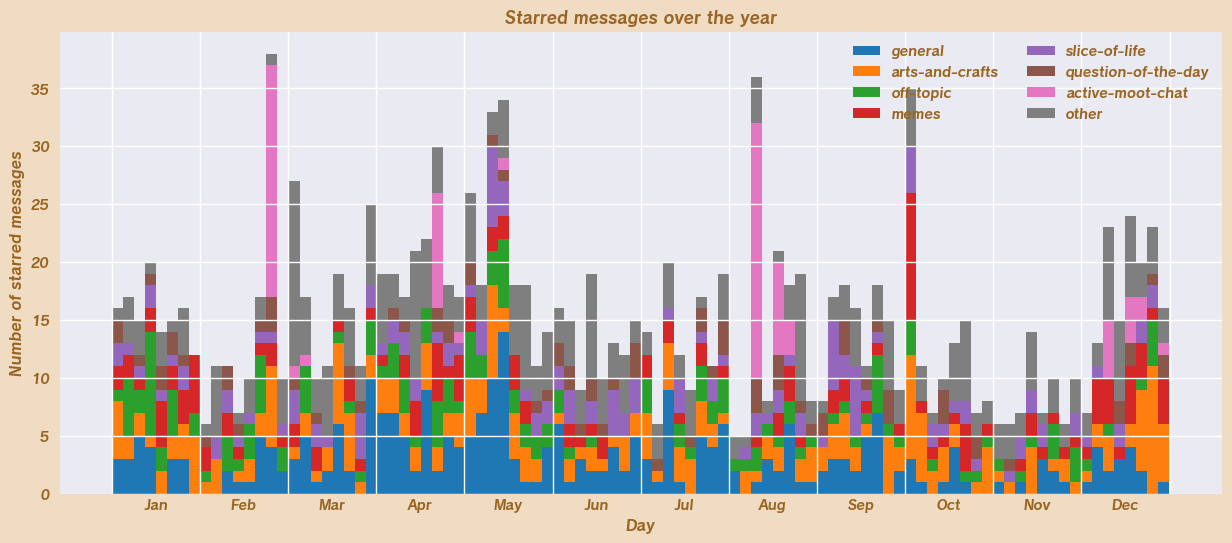

In [21]:
fig, ax = pyplot.subplots(figsize=(15, 6))
pyplot.title('Starred messages over the year', **TITLE)
pyplot.xlabel('Day')
plot_msgs('Y', bins=12 * 8)
pyplot.xticks(np.arange(13) * 365/12, []);
pyplot.xticks(np.arange(12) * 365/12 + 365/24, MONTHS, minor=True);

In [23]:
stats['chan stars'] = stats['stars'] - stats['hall_stars']

Text(0, 0.5, 'Message count')

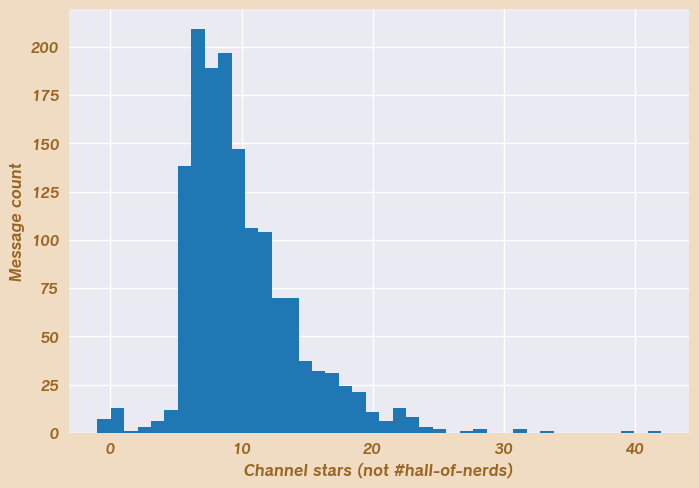

In [31]:
stats['chan stars'].hist(bins=stats['chan stars'].max())
pyplot.xlabel('Channel stars (not #hall-of-nerds)')
pyplot.ylabel('Message count')